### PROJECT ABSTRACT 

With all the code computed on other notebookes:

 **1- Spotify API** - where I did my first connection to the API, providing it with like and disliked songs, as well as my musical journey data.

 **2- EDA** - where I explored all Spotify features based on the two groups in study.

 **3- My Musical Journey** - also a kind of EDA notebook. However, in this one I analysed my top year playlists to evaluate the evolution of my music taste from 2016 to 2019. 

 **4- Supervised ML** - tested multiple suprevised learning classifiers getting to a 86% Accuracy with Random Forest. I have now a pretty good algorithm that aimns to detect if I like a song or not, as well as the prob of that event happening.

 **5- Test on other's playlists** - used the best algorithm evaluated on ML notebook and applied to outside data - songs from friend's playlists - meaning neither data from the traning nor the test set.

 **6- Unsupervised Learning** - without any song labeling, used the whole dataset (liked + disliked songs) to extract knowledge based on any patterns: Clustering, Dimensionality Reduction.

Finally, in this script I aim to produce a final product where the user can input his/hers/theirs **(public) playlsit URI** and get an  **Exploratory Data Analysis on the songs' features, as well as new song recomendations.** This will be produced based on Unsupervised Learning techniques, since we can assume the shared playlist will be a collection of liked songs and therefore we can't apply labelling techniques.

In [42]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
%matplotlib inline
import plotly.express as px

import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
import scipy.cluster.hierarchy as shc

import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_1samp, ttest_rel, ttest_ind
from IPython.display import display, Image, SVG, Math, YouTubeVideo


In [3]:
username = 'britopereiraa'
client_id ='17a3ed14ab434b33b28f19f8bea3337d'
client_secret = '7f848f9d2a024b15be5fa776b4dc7a05'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
def master_function(username, uri):
    uri = playlist_uri    
    username = username
    playlist_id = uri
    results = {'items':[]}

    for n in range(0,3000,100):
        new = sp.user_playlist_tracks(username, playlist_id,  offset = n)
        results['items'] += new['items']

        playlist_tracks_data = results
        playlist_tracks_id = []
        playlist_tracks_titles = []
        playlist_tracks_artists = []

        for track in playlist_tracks_data['items']:
            playlist_tracks_id.append(track['track']['id'])
            playlist_tracks_titles.append(track['track']['name'])

        #adds a list of all artists involved in the song to the list of artists for the playlist
            for artist in track['track']['artists']:
                artist_list = []
                artist_list.append(artist['name'])
            playlist_tracks_artists.append(artist_list[0])
    
    #some tracks might have none id
    playlist_tracks_id = list(filter(None, playlist_tracks_id)) 
    
    df = pd.DataFrame([])
    for i in range(0, len(playlist_tracks_id)):
        features = sp.audio_features(playlist_tracks_id[i])
        features_df = pd.DataFrame(features)
        df = df.append(features_df)
       

    df['title'] = playlist_tracks_titles
    #features_df['first_artist'] = playlist_tracks_first_artists
    df['main_artist'] = playlist_tracks_artists
    #features_df = features_df.set_index('id')
    df = df[['id', 'title', 'main_artist',
                               'danceability', 'energy', 'key', 'loudness',
                               'mode', 'acousticness', 'instrumentalness',
                               'liveness', 'valence', 'tempo',
                               'duration_ms', 'time_signature']]

    return df

### USER PLAYLIST

In [157]:
#input variables
playlist_uri ="2ERd3YQjKnGSEyInrwYPRh"
username = "João Fanha"

In [172]:
df = master_function(username,playlist_uri)
df.shape

(57, 15)

In [173]:
pred_df = kmean.predict(df[features])
df['songs group'] = pred_df

In [174]:
df = df.reset_index()
df = df.drop(columns=['index'])
df.head()

,id,title,main_artist,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,songs group
0,1CsCuwscKV2tYqLeG0p8Q6,Toyota Man,Neon Indian,0.563,0.864,7,-5.313,1,0.0685,0.000005,0.5160,0.896,93.901,252883,4,0
1,6wYTcgNMqPZw2hybRMTEQf,Timebends,Deerhunter,0.369,0.796,10,-8.236,1,0.2250,0.345000,0.2630,0.461,142.902,758151,4,0
2,0uYRKUD994hbQi3JLSt22K,The Left,Duckwrth,0.808,0.703,7,-7.772,1,0.0636,0.005150,0.1050,0.392,90.003,263876,4,0
3,2uJT2q88v5RYhn5XRhAryM,Netflix,Malxs,0.720,0.504,4,-7.658,1,0.1890,0.000000,0.1180,0.377,92.001,159130,4,0
4,2pDKE8Q40TDGPl1O11DKKn,Shameika,Fiona Apple,0.375,0.776,8,-6.767,1,0.1540,0.000082,0.0925,0.647,186.814,248603,4,0


### Get the all songs playlist: 

A playlist with over 5000 songs of all Genre 

In [175]:
features = ['danceability', 'energy', 'key','loudness', 'mode', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo']

#import dataset created in other jupyter notebook
all_songs = pd.read_csv('../data/all_songs.csv')

#drop duplicates
all_songs.drop_duplicates(subset ="id", 
                     keep = False, inplace = True)


#check recomended songs that are not in the playlist already:

all_songs = all_songs.loc[~((all_songs.id.isin(df['id']))),:]
all_songs.head()

,id,title,main_artist,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2aQ8NyRJcsQFgb8jwUil90,Que Bandeira,Evinha,0.755,0.537,1,-10.679,1,0.75600,0.000003,0.3550,0.811,93.393,149420,4
1,6d4KqeYESkFHMirUgE1Aa3,Não Vá,Tim Maia,0.658,0.741,2,-10.495,1,0.04430,0.001280,0.0603,0.928,103.283,307037,4
2,2OoOgl80tDTElnbMYfhJyH,Reggins,The Blackbyrds,0.645,0.383,5,-16.549,0,0.00495,0.611000,0.0727,0.943,97.238,244800,4
3,5voWjUklIhjnNQU5aZCIm4,Dreaming About You,The Blackbyrds,0.744,0.292,4,-16.592,0,0.26500,0.095900,0.0738,0.881,96.366,352400,4
4,2jHa1UWWuouaoFqE8I7W77,Never Let Her Go,David Gates,0.576,0.399,8,-14.764,1,0.23300,0.000022,0.1040,0.621,84.049,188813,4


In [176]:
all_songs.shape

(5147, 15)

In [177]:
#features scaling 
scaler = StandardScaler()
scaler.fit(all_songs[features])

all_songs_features_scaled = scaler.transform(all_songs[features])

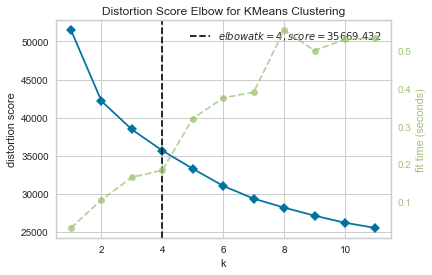

In [178]:
X = all_songs_features_scaled
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


In [179]:
#label the data into clusters

kmean = KMeans(n_clusters=9)
kmean.fit(all_songs_features_scaled)

pred = kmean.labels_
all_songs['labels'] = pred

#check clusters
all_songs.head()

,id,title,main_artist,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,labels
0,2aQ8NyRJcsQFgb8jwUil90,Que Bandeira,Evinha,0.755,0.537,1,-10.679,1,0.75600,0.000003,0.3550,0.811,93.393,149420,4,8
1,6d4KqeYESkFHMirUgE1Aa3,Não Vá,Tim Maia,0.658,0.741,2,-10.495,1,0.04430,0.001280,0.0603,0.928,103.283,307037,4,8
2,2OoOgl80tDTElnbMYfhJyH,Reggins,The Blackbyrds,0.645,0.383,5,-16.549,0,0.00495,0.611000,0.0727,0.943,97.238,244800,4,3
3,5voWjUklIhjnNQU5aZCIm4,Dreaming About You,The Blackbyrds,0.744,0.292,4,-16.592,0,0.26500,0.095900,0.0738,0.881,96.366,352400,4,1
4,2jHa1UWWuouaoFqE8I7W77,Never Let Her Go,David Gates,0.576,0.399,8,-14.764,1,0.23300,0.000022,0.1040,0.621,84.049,188813,4,7


In [180]:
all_songs['labels'].value_counts()

8    934
0    854
7    707
6    584
1    567
3    491
2    461
4    278
5    271
Name: labels, dtype: int64

In [181]:
#PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
df_pca_all_songs = pd.DataFrame(data=pca.fit_transform(all_songs_features_scaled), columns=['PC1','PC2','PC3'])

In [182]:
pca.components_
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26902849 0.13673408 0.11339972]


Text(0, 0.5, 'Principal components')

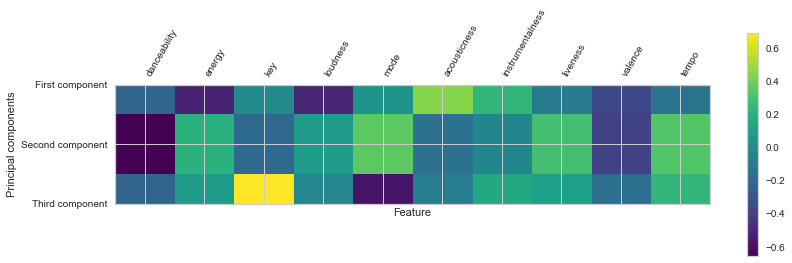

In [183]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1, 2], ["First component", "Second component", "Third component"])
plt.colorbar()
plt.xticks(range(len(all_songs[features].columns)),all_songs[features], rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

In [184]:
df_pca_all_songs = df_pca_all_songs.merge(all_songs, left_index=True, right_index=True)
df_pca_all_songs = df_pca_all_songs[['PC1', 'PC2', 'PC3', 'title', 'main_artist']]

df_pca_all_songs.shape

(5039, 5)

In [187]:
#PCA with friend's playlist

#features scaling 
df_scaled = scaler.transform(df[features])

#use trained PCA
df_pca = pd.DataFrame(data=pca.transform(df_scaled), columns=['PC1','PC2','PC3'])

In [188]:
df_pca = df_pca.merge(df, left_index=True, right_index=True)
df_pca = df_pca[['PC1', 'PC2', 'PC3', 'title', 'main_artist']]

df_pca.head()

,PC1,PC2,PC3,title,main_artist
0,-2.249394,0.680336,-0.246701,Toyota Man,Neon Indian
1,-0.364912,1.736746,1.209383,Timebends,Deerhunter
2,-0.799533,-0.491358,-0.599023,The Left,Duckwrth
3,-0.036552,-0.170136,-1.149241,Netflix,Malxs
4,-1.259950,1.777099,0.728568,Shameika,Fiona Apple


In [190]:
from scipy.spatial import KDTree
columns = ['PC1', 'PC2', 'PC3']

kdB = KDTree(df_pca_all_songs[columns].values)#all songs
print(kdB.query(df_pca[columns].values, k=2)[-1])

#k desired number of neighbors: this case I chose 1 neighbour song
#returns indices of 1-neighbors for all rows/points in our songs "database"

[[2488 2988]
 [3459 4838]
 [2423 2155]
 [4018 1947]
 [4847 3396]
 [4145 4681]
 [1106 1916]
 [2013  406]
 [2294 3514]
 [4507 1627]
 [3066 2374]
 [4968 4223]
 [3620 3088]
 [1457 1268]
 [ 510 2455]
 [1077  628]
 [ 145 3601]
 [1670  414]
 [4342 3390]
 [ 144 3318]
 [ 972 4880]
 [1274 1264]
 [3390 4562]
 [2089 2374]
 [2374 2089]
 [4250 2145]
 [2170 4939]
 [3814  541]
 [ 803 4481]
 [ 391  654]
 [3421 4051]
 [3937 1049]
 [4605 2151]
 [2032 1242]
 [1980 1034]
 [3536 2285]
 [ 957 4218]
 [4972 3120]
 [ 253 1105]
 [2729 4686]
 [3002 1995]
 [4318 2063]
 [2451 1964]
 [1652 1870]
 [4811 1749]
 [3469 3465]
 [2698 3602]
 [4033 3193]
 [1767 1686]
 [1801 2949]
 [4471 3914]
 [1874 4340]
 [1778  656]
 [1596 1540]
 [ 874 1088]
 [ 846  141]
 [1223 2216]]


In [191]:
recommendations.loc[2488]

id                  6L3VsjOK656g3MEqckfVzA
title                 Todo Homem - Ao Vivo
main_artist                     Tom Veloso
danceability                           0.4
energy                              0.0919
key                                      1
loudness                           -18.302
mode                                     1
acousticness                         0.986
instrumentalness                     0.675
liveness                             0.101
valence                             0.0672
tempo                              105.395
duration_ms                         216781
time_signature                           4
labels                                   8
Name: 2488, dtype: object

In [192]:
df.loc[0]

id                  1CsCuwscKV2tYqLeG0p8Q6
title                           Toyota Man
main_artist                    Neon Indian
danceability                         0.563
energy                               0.864
key                                      7
loudness                            -5.313
mode                                     1
acousticness                        0.0685
instrumentalness                  5.04e-06
liveness                             0.516
valence                              0.896
tempo                               93.901
duration_ms                         252883
time_signature                           4
songs group                              0
Name: 0, dtype: object